# Miscellaneous workflows with Datalab

This tutorial demonstrates various useful things you can do with `Datalab` that may not be covered in other tutorials. First get familiar with `Datalab` via the [quickstart](datalab_quickstart.html)/[advanced](datalab_advanced.html) tutorials before going through this one.

## Accelerate Issue Checks with Pre-computed kNN Graphs

By default, `Datalab` will detect certain types of issues by constructing a k-nearest neighbors graph of your dataset using the [scikit-learn](https://scikit-learn.org/stable/modules/neighbors.html) package. Here we demonstrate how to use your own pre-computed k-nearest neighbors (kNN) graphs with `Datalab`. This allows you to use more efficient approximate kNN graphs to scale to bigger datasets.

Using pre-computed kNN graphs is optional and not required for `Datalab` to function. `Datalab` can automatically compute these graphs for you.

While we use a toy dataset for demonstration, these steps can be applied to any dataset.

### 1. Load and Prepare Your Dataset

Here we'll generate a synthetic dataset, but you should replace this with your own dataset loading process.

In [1]:
import numpy as np
from sklearn.datasets import make_classification

# Set seed for reproducibility
np.random.seed(0)

# Replace this section with your own dataset loading
# For demonstration, we create a synthetic classification dataset
X, y = make_classification(
    n_samples=5000,
    n_features=5,
    n_informative=5,
    n_redundant=0,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    flip_y=0.02,
    class_sep=2.0,
    shuffle=False,
    random_state=0,
)


# Example: Add a duplicate example to the dataset
X[-1] = X[-2] + np.random.rand(5) * 0.001

### 2. Compute kNN Graph

We will compute the kNN graph using [FAISS](https://github.com/facebookresearch/faiss), a library for efficient similarity search. This step involves creating a kNN graph that represents the nearest neighbors for each point in your dataset.

In [2]:
import faiss
import numpy as np

# Faiss uses single precision, so we need to convert the data type
X_faiss = np.float32(X)

# Normalize the vectors for inner product similarity (effectively cosine similarity)
faiss.normalize_L2(X_faiss)

# Build the index using FAISS
index = faiss.index_factory(X_faiss.shape[1], "HNSW32,Flat", faiss.METRIC_INNER_PRODUCT)

# Add the dataset to the index
index.add(X_faiss)

# Perform the search to find k-nearest neighbors
k = 10  # Number of neighbors to consider
D, I = index.search(X_faiss, k + 1)  # Include the point itself during search

# Remove the first column (self-distances)
D, I = D[:, 1:], I[:, 1:]

# Convert cosine similarity to cosine distance
np.clip(1 - D, a_min=0, a_max=None, out=D)

# Create the kNN graph
from scipy.sparse import csr_matrix


def create_knn_graph(distances: np.ndarray, indices: np.ndarray) -> csr_matrix:
    """
    Create a K-nearest neighbors (KNN) graph in CSR format from provided distances and indices.

    Parameters:
    distances (np.ndarray): 2D array of shape (n_samples, n_neighbors) containing distances to nearest neighbors.
    indices (np.ndarray): 2D array of shape (n_samples, n_neighbors) containing indices of nearest neighbors.

    Returns:
    scipy.sparse.csr_matrix: KNN graph in CSR format.
    """
    assert distances.shape == indices.shape, "distances and indices must have the same shape"

    n_samples, n_neighbors = distances.shape

    # Convert to 1D arrays for CSR matrix creation
    indices_1d = indices.ravel()
    distances_1d = distances.ravel()
    indptr = np.arange(0, n_samples * n_neighbors + 1, n_neighbors)

    # Create the CSR matrix
    return csr_matrix((distances_1d, indices_1d, indptr), shape=(n_samples, n_samples))


knn_graph = create_knn_graph(D, I)

# Ensure the kNN graph is sorted by row values
from sklearn.neighbors import sort_graph_by_row_values
sort_graph_by_row_values(knn_graph, copy=False, warn_when_not_sorted=False)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 50000 stored elements and shape (5000, 5000)>

### 3. Train a Classifier and Obtain Predicted Probabilities

Predicted class probabilities from a model trained on your dataset are used to identify label issues.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Obtain predicted probabilities using cross-validation
clf = LogisticRegression()
pred_probs = cross_val_predict(clf, X, y, cv=3, method="predict_proba")

### 4. Identify Data Issues Using Datalab
Use the pre-computed kNN graph and predicted probabilities to find issues in the dataset using `Datalab`.

In [4]:
from cleanlab import Datalab

# Initialize Datalab with the dataset
lab = Datalab(data={"X": X, "y": y}, label_name="y", task="classification")

# Perform issue detection using the kNN graph and predicted probabilities, when possible
lab.find_issues(knn_graph=knn_graph, pred_probs=pred_probs, features=X)

# Collect the identified issues and a summary
issues = lab.get_issues()
issue_summary = lab.get_issue_summary()

# Display the issues and summary
display(issue_summary)
display(issues)

Finding null issues ...
Finding label issues ...


Finding outlier issues ...
Finding near_duplicate issues ...
Finding non_iid issues ...
Finding class_imbalance issues ...
Finding underperforming_group issues ...

Audit complete. 524 issues found in the dataset.


,issue_type,score,num_issues
0,null,1.000000,0
1,label,0.991400,52
2,outlier,0.356925,363
3,near_duplicate,0.619581,108
4,non_iid,0.000000,1
5,class_imbalance,0.500000,0
6,underperforming_group,0.651838,0


,is_null_issue,null_score,is_label_issue,label_score,is_outlier_issue,outlier_score,is_near_duplicate_issue,near_duplicate_score,is_non_iid_issue,non_iid_score,is_class_imbalance_issue,class_imbalance_score,is_underperforming_group_issue,underperforming_group_score
0,False,1.0,False,0.999827,True,0.031217,False,0.933716,False,0.627345,False,0.5,False,1.0
1,False,1.0,False,0.998540,False,0.530909,False,0.296974,False,0.646765,False,0.5,False,1.0
2,False,1.0,False,0.942721,False,0.332824,False,0.803246,False,0.625202,False,0.5,False,1.0
3,False,1.0,False,0.999816,False,0.474031,False,0.706253,False,0.655108,False,0.5,False,1.0
4,False,1.0,False,0.997703,False,0.131466,False,0.912389,False,0.639200,False,0.5,False,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,False,1.0,False,0.998646,False,0.504755,False,0.746777,False,0.680033,False,1.0,False,1.0
4996,False,1.0,False,0.894230,False,0.340986,False,0.816472,False,0.640711,False,1.0,False,1.0
4997,False,1.0,False,0.999100,False,0.428545,False,0.592421,False,0.658949,False,1.0,False,1.0
4998,False,1.0,False,0.986792,False,0.273710,True,0.000000,False,0.618033,False,1.0,False,1.0


#### Explanation:

**Creating the kNN Graph:**

- Compute the kNN graph using FAISS or another library, ensuring the self-points (points referring to themselves) are omitted from the neighbors.
  - Some distance kernels or search algorithms (like those in FAISS) may return negative distances or suffer from numerical instability when comparing
    points that are extremely close to each other. This can lead to incorrect results when constructing the kNN graph.
  - **Note**: kNN graphs are generally poorly suited for detecting exact duplicates, especially when the number of exact duplicates exceeds the number of requested neighbors. The strengths of this data structure lie in the assumption that data points are similar but not identical, allowing efficient similarity searches and proximity-based analyses.
  - If you are comfortable with exploring non-public API functions in the library, you can use the following helper function to ensure that exact duplicate sets are correctly represented in the kNN graph. Please note, this function is not officially supported and is not part of the public API:

    ```python
    from cleanlab.internal.neighbor.knn_graph import correct_knn_graph

    knn_graph = correct_knn_graph(features=X_faiss, knn_graph=knn_graph)
    ```
- You may need to handle self-points yourself with third-party libraries.
- Construct the CSR (Compressed Sparse Row) matrix from the distances and indices arrays.
  - `Datalab` can automatically construct a kNN graph from a numerical `features` array if one is not provided, in an accurate and reliable manner.
- Sort the kNN graph by row values.

When using approximate kNN graphs, it is important to understand their strengths and limitations to apply them effectively.

## Data Valuation

In this section, we will show how to use `Datalab` to estimate how much each data point contributes to a trained classifier model. Data valuation helps you understand the importance of each data point, where you can identify more/less valuable data points for your machine learning models.

We will use a text dataset for this example, but this approach can be applied to any dataset.

### 1. Load and Prepare the Dataset
We will use a subset of the 20 Newsgroups dataset, which is a collection of newsgroup documents suitable for text classification tasks.
For demonstration purposes, we'll classify documents from two categories: "alt.atheism" and "sci.space".

In [5]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd

# Load the 20 Newsgroups dataset
newsgroups_train = fetch_20newsgroups(subset='train', categories=['alt.atheism', 'sci.space'], remove=('headers', 'footers', 'quotes'))

# Create a DataFrame with the text data and labels
df_text = pd.DataFrame({"Text": newsgroups_train.data, "Label": newsgroups_train.target})
df_text["Label"] = df_text["Label"].map({i: category for (i, category) in enumerate(newsgroups_train.target_names)})

# Display the first few samples
df_text.head()

,Text,Label
0,: \n: >> Please enlighten me. How is omnipote...,alt.atheism
1,In <19APR199320262420@kelvin.jpl.nasa.gov> baa...,sci.space
2,"\nHenry, I made the assumption that he who get...",sci.space
3,\n\n\nNo. I estimate a 99 % probability the Ge...,sci.space
4,\nLucky for them that the baby didn't have any...,alt.atheism


### 2. Vectorize the Text Data
We will use a `TfidfVectorizer` to convert the text data into a numerical format suitable for machine learning models.

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TfidfVectorizer
vectorizer = TfidfVectorizer()

# Transform the text data into a feature matrix
X_vectorized = vectorizer.fit_transform(df_text["Text"])

# Convert the sparse matrix to a dense matrix
X = X_vectorized.toarray()

### 3. Perform Data Valuation with Datalab

Next, we will initialize `Datalab` and perform data valuation to assess the value of each data point in the dataset.

In [7]:
from cleanlab import Datalab

# Initialize Datalab with the dataset
lab = Datalab(data=df_text, label_name="Label", task="classification")

# Perform data valuation
lab.find_issues(features=X, issue_types={"data_valuation": {}})

# Collect the identified issues
data_valuation_issues = lab.get_issues("data_valuation")

# Display the data valuation issues
display(data_valuation_issues)

Finding data_valuation issues ...



Audit complete. 147 issues found in the dataset.


,is_data_valuation_issue,data_valuation_score
0,False,0.500047
1,False,0.500093
2,False,0.500000
3,False,0.500047
4,True,0.499953
...,...,...
1068,False,0.500000
1069,False,0.500000
1070,False,0.500047
1071,False,0.500000


### 4. (Optional) Visualize Data Valuation Scores
Let's visualize the data valuation scores across our dataset.

Cleanlab's Shapely scores are transformed to lie between 0 and 1 such that: a score below 0.5 indicates a negative contribution to the model's training performance, while a score above 0.5 indicates a positive contribution.

By examining the scores across different classes, we can identify whether positive or negative contributions are disproportionately concentrated in a single class. This can help detect biases in the training data.

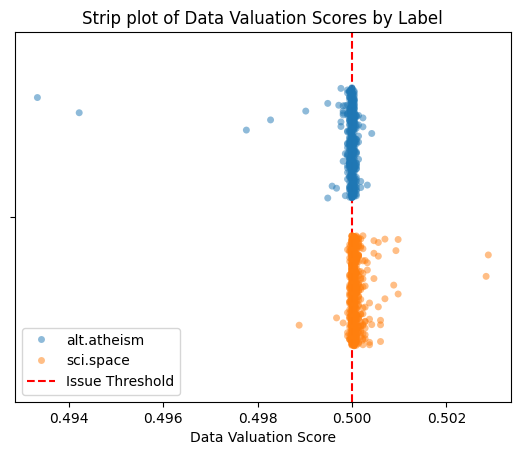

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare the data for plotting
plot_data = (
    data_valuation_issues
    # Optionally, add a 'given_label' column to distinguish between labels in the histogram
    .join(pd.DataFrame({"given_label": df_text["Label"]}))
)

# Plot strip plots of data valuation scores for each label
sns.stripplot(
    data=plot_data,
    x="data_valuation_score",
    hue="given_label",  # Comment out if no labels should be used in the visualization
    dodge=True,
    jitter=0.3,
    alpha=0.5,
)

plt.axvline(lab.info["data_valuation"]["threshold"], color="red", linestyle="--", label="Issue Threshold")

plt.title("Strip plot of Data Valuation Scores by Label")
plt.xlabel("Data Valuation Score")
plt.legend()
plt.show()

Learn more about the data valuation issue type in the [Issue Type Guide](../../cleanlab/datalab/guide/issue_type_description.html#data-valuation-issue).

## Find Underperforming Groups in a Dataset

Here we will demonstrate how to use `Datalab` to identify subgroups in a dataset over which the ML model is producing consistently worse predictions than for the overall dataset.

`Datalab` will automatically find underperforming groups if you provide numerical embeddings and predicted probabilities from any model.
For this section, we'll determine which data subgroups to consider ourselves, such as by using clustering.


### 1. Generate a Synthetic Dataset

First, we will generate a synthetic dataset with blobs. This dataset will include some noisy labels in one of the blobs.

In [9]:
from sklearn.datasets import make_blobs
import numpy as np

# Generate synthetic data with blobs
X, y = make_blobs(n_samples=100, centers=3, n_features=2, random_state=42, cluster_std=1.0, shuffle=False)

# Add noise to the labels
n_noisy_labels = 30
y[:n_noisy_labels] = np.random.randint(0, 2, n_noisy_labels)

### 2. Train a Classifier and Obtain Predicted Probabilities

Next, we will train a basic classifier (you can use any type of model) and obtain predicted probabilities for the dataset using cross-validation.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Obtain predicted probabilities using cross-validation
clf = LogisticRegression(random_state=0)
pred_probs = cross_val_predict(clf, X, y, cv=3, method="predict_proba")

### 3. (Optional) Cluster the Data

Datalab identifies meaningful data subgroups by automatically clustering your dataset.
You can optionally provide your own clusters to control this process. Here we show how to use KMeans clustering, but this manual clustering is entirely optional.

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV


# Function to use in GridSearchCV for silhouette score
def silhouette_scorer(estimator, X):
    cluster_labels = estimator.fit_predict(X)
    return silhouette_score(X, cluster_labels)


# Use GridSearchCV to determine the optimal number of clusters
param_grid = {"n_clusters": range(2, 10)}
grid_search = GridSearchCV(KMeans(random_state=0), param_grid, cv=3, scoring=silhouette_scorer)
grid_search.fit(X)

# Get the best estimator and predict clusters
best_kmeans = grid_search.best_estimator_
cluster_ids = best_kmeans.fit_predict(X)

### 4. Identify Underperforming Groups with Datalab

We will use `Datalab` to find underperforming groups in the dataset based on the predicted probabilities and optionally the cluster assignments.

In [12]:
from cleanlab import Datalab
import pandas as pd

# Initialize Datalab with the dataset
lab = Datalab(data={"X": X, "y": y}, label_name="y", task="classification")

# Find issues related to underperforming groups, optionally using cluster_ids
lab.find_issues(
    # features=X  # Uncomment this line if 'cluster_ids' is not provided to allow Datalab to run clustering automatically.
    pred_probs=pred_probs,
    issue_types={
        "underperforming_group": {
            "threshold": 0.75,          # Set a custom threshold for identifying underperforming groups.
                                        # The default threshold is lower, optimized for higher precision (fewer false positives),
                                        # but for this toy example, a higher threshold increases sensitivity to underperforming groups.
            "cluster_ids": cluster_ids  # Optional: Provide cluster IDs if clustering is used.
                                        # If not provided, Datalab will automatically run clustering under the hood.
                                        # In that case, you need to provide the 'features' array as an additional argument.
            },
    },
)

# Collect the identified issues
underperforming_group_issues = lab.get_issues("underperforming_group").query("is_underperforming_group_issue")

# Display the issues along with given and predicted labels
display(underperforming_group_issues.join(pd.DataFrame({"given_label": y, "predicted_label": pred_probs.argmax(axis=1)})))

Finding underperforming_group issues ...

Audit complete. 11 issues found in the dataset.


,is_underperforming_group_issue,underperforming_group_score,given_label,predicted_label
3,True,0.328308,0,0
6,True,0.328308,1,0
7,True,0.328308,0,0
8,True,0.328308,1,0
13,True,0.328308,1,0
14,True,0.328308,1,0
15,True,0.328308,1,0
21,True,0.328308,1,0
22,True,0.328308,1,0
28,True,0.328308,0,1


### 5. (Optional) Visualize the Results

Finally, we will optionally visualize the dataset, highlighting the underperforming groups identified by `Datalab`.

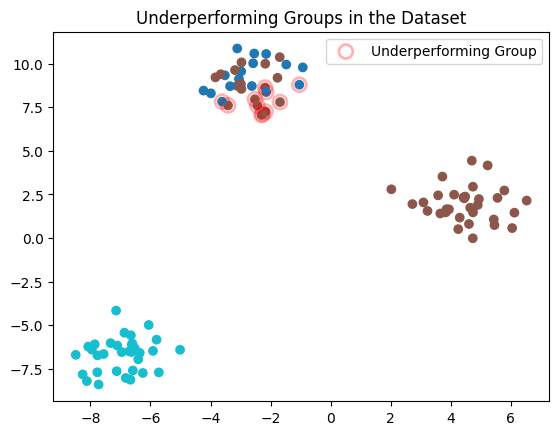

In [13]:
import matplotlib.pyplot as plt

# Plot the original data points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="tab10")

# Highlight the underperforming group (if any issues are detected)
if not underperforming_group_issues.empty:
    plt.scatter(
        X[underperforming_group_issues.index, 0], X[underperforming_group_issues.index, 1],
        s=100, facecolors='none', edgecolors='r', alpha=0.3, label="Underperforming Group", linewidths=2.0
    )
else:
    print("No underperforming group issues detected.")

# Add title and legend
plt.title("Underperforming Groups in the Dataset")
plt.legend()
plt.show()

Learn more about the underperforming group issue type in the [Issue Type Guide](../../cleanlab/datalab/guide/issue_type_description.html#underperforming-group-issue).

## Predefining Data Slices for Detecting Underperforming Groups

Instead of clustering the data to determine what data slices are considered when detecting underperforming groups, you can define these slices yourself.
For say a tabular dataset, you can use the values of a categorical column as cluster IDs to predefine the relevant data subgroups/slices to consider. This allows you to focus on meaningful slices of your data defined by domain knowledge or specific attributes.

### 1. Load and Prepare the Dataset

We'll work with a toy tabular dataset with several categorical and numerical columns, just to illustrate how to use predefined data slices for detecting underperforming groups.

In [14]:
# Define the dataset as a multi-line string
dataset_tsv = """
Age	Gender	Location	Education	Experience	HighSalary
60	Other	Indiana	PhD	21	0
50	Male	Indiana	Bachelor's	21	0
36	Female	Indiana	PhD	21	0
64	Male	Kansas	High School	37	1
29	Male	Kansas	PhD	14	0
42	Male	Ohio	PhD	7	0
60	Male	Kansas	High School	26	0
40	Other	Ohio	Bachelor's	25	0
44	Male	Indiana	High School	29	0
32	Male	Ohio	PhD	17	0
32	Male	Kansas	Bachelor's	17	0
45	Other	Ohio	PhD	30	0
57	Male	California	High School	27	1
61	Male	Kansas	High School	32	0
45	Other	Indiana	PhD	4	0
24	Other	Kansas	Bachelor's	9	0
43	Other	Ohio	Master's	3	0
23	Male	Ohio	High School	8	0
45	Other	Kansas	High School	16	0
51	Other	Ohio	Master's	27	0
59	Male	Ohio	Master's	29	0
23	Other	Indiana	Bachelor's	8	0
42	Male	Kansas	PhD	5	0
54	Female	Kansas	Master's	34	0
33	Other	Kansas	PhD	18	0
43	Female	Kansas	PhD	23	0
46	Male	Ohio	Bachelor's	28	0
48	Other	Ohio	PhD	30	0
63	Male	Kansas	High School	34	0
49	Female	Kansas	PhD	32	1
37	Male	Kansas	PhD	20	0
36	Other	Indiana	Master's	21	1
24	Other	Indiana	High School	9	0
58	Female	Kansas	PhD	32	0
28	Male	California	Master's	2	0
42	Other	Kansas	Bachelor's	17	0
30	Female	California	PhD	15	1
60	Other	Ohio	PhD	30	0
39	Other	Kansas	Bachelor's	2	0
25	Male	Ohio	Master's	10	0
46	Other	Indiana	PhD	23	0
35	Male	Indiana	Bachelor's	20	0
30	Other	Ohio	High School	15	0
47	Female	Ohio	Master's	22	0
23	Other	Ohio	High School	1	0
41	Male	Ohio	High School	26	0
49	Male	Kansas	Bachelor's	1	0
28	Female	Ohio	Master's	13	0
29	Other	Kansas	Bachelor's	14	0
56	Other	Indiana	Bachelor's	39	1
35	Female	Ohio	Bachelor's	20	0
38	Other	California	Bachelor's	8	1
57	Other	Ohio	Master's	38	1
61	Male	Indiana	PhD	28	0
25	Other	Indiana	High School	10	0
23	Other	Kansas	High School	8	0
27	Female	Ohio	Master's	12	0
63	Female	Indiana	High School	23	0
25	Male	Indiana	Master's	10	0
50	Other	Ohio	High School	6	0
39	Other	Kansas	Bachelor's	24	0
47	Other	Indiana	High School	19	0
55	Male	Indiana	PhD	0	0
31	Male	Ohio	PhD	7	0
57	Female	Kansas	PhD	15	0
35	Male	California	PhD	13	0
52	Other	Ohio	PhD	11	0
36	Other	Ohio	Master's	21	0
29	Male	Indiana	Master's	14	0
35	Other	Indiana	High School	20	0
44	Other	Indiana	PhD	29	1
61	Male	Kansas	High School	1	0
42	Male	Ohio	PhD	27	0
37	Other	Indiana	PhD	22	0
39	Other	Kansas	Master's	21	0
"""

# Import necessary libraries
from io import StringIO
import pandas as pd

# Load the dataset into a DataFrame
df = pd.read_csv(
    StringIO(dataset_tsv),
    sep='\t',
)

# Display the original DataFrame
display(df)

,Age,Gender,Location,Education,Experience,HighSalary
0,60,Other,Indiana,PhD,21,0
1,50,Male,Indiana,Bachelor's,21,0
2,36,Female,Indiana,PhD,21,0
3,64,Male,Kansas,High School,37,1
4,29,Male,Kansas,PhD,14,0
...,...,...,...,...,...,...
70,44,Other,Indiana,PhD,29,1
71,61,Male,Kansas,High School,1,0
72,42,Male,Ohio,PhD,27,0
73,37,Other,Indiana,PhD,22,0


**Optional**: The categorical features of the dataset can encoded to numerical values for easier. For simplicity, y, we will use `OrdinalEncoder` from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html).

In [15]:
from sklearn.preprocessing import OrdinalEncoder

# Encode the categorical columns
columns_to_encode = ["Gender", "Location", "Education"]
encoded_df = df.copy()
encoder = OrdinalEncoder(dtype=int)
encoded_df[columns_to_encode] = encoder.fit_transform(encoded_df[columns_to_encode])
# encoded_df.drop(columns=["Salary"], inplace=True)

# Display the encoded DataFrame
display(encoded_df)

,Age,Gender,Location,Education,Experience,HighSalary
0,60,2,1,3,21,0
1,50,1,1,0,21,0
2,36,0,1,3,21,0
3,64,1,2,1,37,1
4,29,1,2,3,14,0
...,...,...,...,...,...,...
70,44,2,1,3,29,1
71,61,1,2,1,1,0
72,42,1,3,3,27,0
73,37,2,1,3,22,0


### 2. Train a Classifier and Obtain Predicted Probabilities

Next, we will train a basic classifier (you can use any type of model) and obtain predicted probabilities for the dataset using cross-validation.

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# Split data
X = encoded_df.drop(columns=["HighSalary"])
y = encoded_df["HighSalary"]

# Obtain predicted probabilities using cross-validation
clf = LogisticRegression(random_state=0)
pred_probs = cross_val_predict(clf, X, y, cv=3, method="predict_proba")

### 3. Define a Data Slice

For a tabular dataset, you can use a categorical column’s values as pre-computed data slices, so that Datalab skips its default clustering step and directly uses the encoded values for each row in the
dataset.

For this example, we'll focus our attention to the `"Location"` column which has 4 unique categorical values.

In [17]:
cluster_ids = encoded_df["Location"].to_numpy()

### 4. Identify Underperforming Groups with Datalab

Now use `Datalab` to detect underperforming groups in the dataset based on the model predicted probabilities and our predefined data slices.

In [18]:
from cleanlab import Datalab

# Initialize Datalab with the dataset
lab = Datalab(data=df, label_name="HighSalary", task="classification")

# Find issues related to underperforming groups, optionally using cluster_ids
lab.find_issues(
    # features=X  # Uncomment this line if 'cluster_ids' is not provided to allow Datalab to run clustering automatically.
    pred_probs=pred_probs,
    issue_types={
        "underperforming_group": {
            "threshold": 0.75,          # Set a custom threshold for identifying underperforming groups.
                                        # The default threshold is lower, optimized for higher precision (fewer false positives),
                                        # but for this toy example, a higher threshold increases sensitivity to underperforming groups.
            "cluster_ids": cluster_ids  # Optional: Provide cluster IDs if manual data-slicing is used.
                                        # If not provided, Datalab will automatically run clustering under the hood.
                                        # In that case, you need to provide the 'features' array as an additional argument.
            },
    },
)

# Collect the identified issues
underperforming_group_issues = lab.get_issues("underperforming_group").query("is_underperforming_group_issue")

# Display the issues along with given and predicted labels
display(underperforming_group_issues.join(pd.DataFrame({"given_label": y, "predicted_label": pred_probs.argmax(axis=1)})))

Finding underperforming_group issues ...

Audit complete. 5 issues found in the dataset.


,is_underperforming_group_issue,underperforming_group_score,given_label,predicted_label
12,True,0.573681,1,1
34,True,0.573681,0,0
36,True,0.573681,1,0
51,True,0.573681,1,0
65,True,0.573681,0,0


## Detect if your dataset is non-IID

Here we demonstrate how to discover when your data might violate the foundational IID assumption that underpins most machine learning and analytics.
Common violations (that can be caught with `Datalab`) include: data drift, or lack of statistical independence where different data points affect one another.
For this demonstration, we'll work with a 2D dataset where the data points are not independent.

### 1. Load and Prepare the Dataset

For simplicity, we'll just work with a numerical dataset. If your data are not numerical, we recommend using numeric model embeddings of the data.

This issue check is automatically run by `Datalab` whenever you provide numerical data embeddings or predicted probabilities.

In [19]:
import numpy as np

# Set seed for reproducibility
np.random.seed(0)


def generate_data_dependent(num_samples):
    a1, a2, a3 = 0.6, 0.375, -0.975
    X = [np.random.normal(1, 1, 2) for _ in range(3)]
    X.extend(a1 * X[i-1] + a2 * X[i-2] + a3 * X[i-3] for i in range(3, num_samples))
    return np.array(X)


X = generate_data_dependent(50)

### 2. Detect Non-IID Issues Using Datalab

In [20]:
from cleanlab import Datalab

# Initialize Datalab with the dataset
lab = Datalab(data={"X": X})

# Perform data valuation
lab.find_issues(features=X, issue_types={"non_iid": {}})

# Collect the identified issues
non_iid_issues = lab.get_issues("non_iid")

# Display the non-iid issues
display(non_iid_issues.head(10))

Finding non_iid issues ...

Audit complete. 1 issues found in the dataset.


,is_non_iid_issue,non_iid_score
0,False,0.796474
1,False,0.842432
2,False,0.922562
3,False,0.820759
4,False,0.873136
5,False,0.887373
6,False,0.825101
7,False,0.855875
8,True,0.751795
9,False,0.835796


### 3. (Optional) Visualize the Results

Finally, we'll visualize the dataset and highlight the non-iid issues detected by `Datalab`.

Note that only the dataset as a whole can be considered to be non-iid, but no individual data point can be considered non-iid.

To be compatible with `Datalab`, the point with the lowest non-iid score is assigned the `is_non_iid_issue` flag if the entire dataset
is considered non-iid.

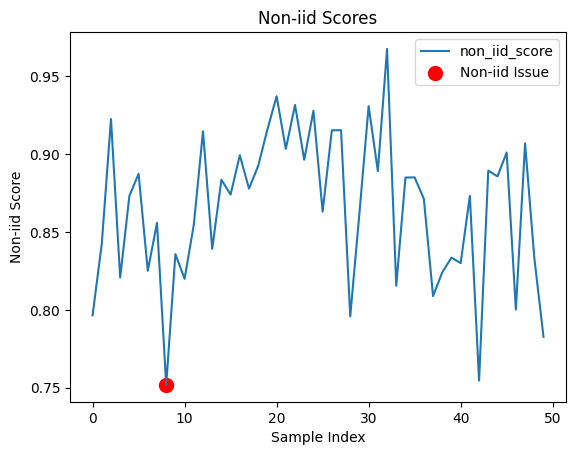

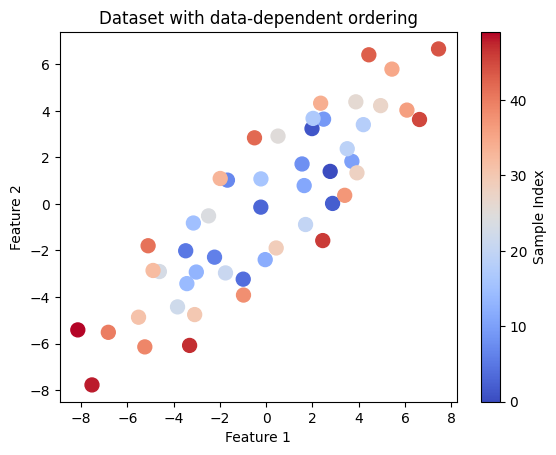

In [21]:
import matplotlib.pyplot as plt

# Plot the non-iid scores
non_iid_issues["non_iid_score"].plot()

# Highlight the point assigned as a non-iid issue
idx = non_iid_issues.query("is_non_iid_issue").index
plt.scatter(idx, non_iid_issues.loc[idx, "non_iid_score"], color='red', label='Non-iid Issue', s=100)
plt.title("Non-iid Scores")
plt.xlabel("Sample Index")
plt.ylabel("Non-iid Score")
plt.legend()
plt.show()

# Visualize dataset ordering
plt.scatter(X[:, 0], X[:, 1], c=range(len(X)), cmap='coolwarm', s=100)
plt.title("Dataset with data-dependent ordering")
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# Add colorbar
plt.colorbar(label='Sample Index')
plt.show()

These plots help visualize the non-iid scores for each data point and the dataset ordering, highlighting potential dependencies and issues.

After detecting non-iid issues, you might be interested in quantifying the likelihood that your dataset is non-iid.

To check if your data is non-iid, `Datalab` computes a p-value. A low p-value (close to 0) indicates strong evidence against the null hypothesis that the data is iid, either because the data appear to be drifting in distribution or inter-dependent across samples.

In [22]:
print("p-value:", lab.get_info("non_iid")["p-value"])

p-value: 0.0


Learn more about the non-iid issue type in the [Issue Type Guide](../../cleanlab/datalab/guide/issue_type_description.html#non-iid-issue).

## Catch Null Values in a Dataset

Here we demonstrate how to use `Datalab` to catch null values in a dataset and visualize them. Models may learn incorrect patterns if null values are present, and may even error during model training. Dealing with null values can mitigate those risks. 

While `Datalab` automatically runs this check by default, this section dives deeper into how to detect the effect of null values in your dataset.

### 1. Load the Dataset

First, we will load the dataset into a Pandas DataFrame. For simplicity, we will use a dataset in TSV (tab-separated values) format.
Some care is needed when loading the dataset to ensure that the data is correctly parsed.


In [23]:
# Define the dataset as a multi-line string
dataset_tsv = """
Age	Gender	Location	Annual_Spending	Number_of_Transactions	Last_Purchase_Date
56.0	Other	Rural	4099.62	3	2024-01-03
NaN	Female	Rural	6421.16	5	NaT
46.0	Male	Suburban	5436.55	3	2024-02-26
32.0	Female	Rural	4046.66	3	2024-03-23
60.0	Female	Suburban	3467.67	6	2024-03-01
25.0	Female	Suburban	4757.37	4	2024-01-03
38.0	Female	Rural	4199.53	6	2024-01-03
56.0	Male	Suburban	4991.71	6	2024-04-03
NaN
NaN	Male	Rural	4655.82	1	NaT
40.0	Female	Rural	5584.02	7	2024-03-29
28.0	Female	Urban	3102.32	2	2024-04-07
28.0	Male	Rural	6637.99	11	2024-04-08
NaN	Male	Urban	9167.47	4	2024-01-02
NaN	Male	Rural	6790.46	3	NaT
NaN	Other	Rural	5327.96	8	2024-01-03
"""

# Import necessary libraries
from io import StringIO
import pandas as pd

# Load the dataset into a DataFrame
df = pd.read_csv(
    StringIO(dataset_tsv),
    sep='\t',
    parse_dates=["Last_Purchase_Date"],
)

# Display the original DataFrame
display(df)

,Age,Gender,Location,Annual_Spending,Number_of_Transactions,Last_Purchase_Date
0,56.0,Other,Rural,4099.62,3.0,2024-01-03
1,NaN,Female,Rural,6421.16,5.0,NaT
2,46.0,Male,Suburban,5436.55,3.0,2024-02-26
3,32.0,Female,Rural,4046.66,3.0,2024-03-23
4,60.0,Female,Suburban,3467.67,6.0,2024-03-01
5,25.0,Female,Suburban,4757.37,4.0,2024-01-03
6,38.0,Female,Rural,4199.53,6.0,2024-01-03
7,56.0,Male,Suburban,4991.71,6.0,2024-04-03
8,NaN,NaN,NaN,NaN,NaN,NaT
9,NaN,Male,Rural,4655.82,1.0,NaT


### 2: Encode Categorical Values

The `features` argument to `Datalab.find_issues()` generally requires a numerical array.
Therefore, we need to numerically encode any categorical values. A common workflow is to encode categorical values in the dataset before passing it to the `find_issues` method (or provide model embeddings of the data instead of the data values themselves).
However, some encoding strategies may lose the original null values.

Here's a strategy to encode categorical columns while keeping the original DataFrame structure intact:

In [24]:
# Define a function to encode categorical columns
def encode_categorical_columns(df, columns, drop=True, inplace=False):
    if not inplace:
        df = df.copy()
    for column in columns:
        # Drop NaN values or replace them with a placeholder
        categories = df[column].dropna().unique()

        # Create a mapping from categories to numbers
        category_to_number = {category: idx for idx, category in enumerate(categories)}

        # Apply the mapping to the column
        df[column + '_encoded'] = df[column].map(category_to_number)

    if drop:
        df = df.drop(columns=columns)

    return df


# Encode the categorical columns
columns_to_encode = ["Gender", "Location"]
encoded_df = encode_categorical_columns(df, columns=columns_to_encode)

# Display the encoded DataFrame
display(encoded_df)

,Age,Annual_Spending,Number_of_Transactions,Last_Purchase_Date,Gender_encoded,Location_encoded
0,56.0,4099.62,3.0,2024-01-03,0.0,0.0
1,NaN,6421.16,5.0,NaT,1.0,0.0
2,46.0,5436.55,3.0,2024-02-26,2.0,1.0
3,32.0,4046.66,3.0,2024-03-23,1.0,0.0
4,60.0,3467.67,6.0,2024-03-01,1.0,1.0
5,25.0,4757.37,4.0,2024-01-03,1.0,1.0
6,38.0,4199.53,6.0,2024-01-03,1.0,0.0
7,56.0,4991.71,6.0,2024-04-03,2.0,1.0
8,NaN,NaN,NaN,NaT,NaN,NaN
9,NaN,4655.82,1.0,NaT,2.0,0.0


### 3. Initialize Datalab

Next, we initialize `Datalab` with the original DataFrame, which will help us discover all kinds of data issues.

In [25]:
# Import the Datalab class from cleanlab
from cleanlab import Datalab

# Initialize Datalab with the original DataFrame
lab = Datalab(data=df)

### 4. Detect Null Values
We will use the find_issues method from `Datalab` to detect null values in our dataset.

In [26]:
# Detect issues in the dataset, focusing on null values
lab.find_issues(features=encoded_df, issue_types={"null": {}})

# Display the identified issues
null_issues = lab.get_issues("null")
display(null_issues)

Finding null issues ...

Audit complete. 1 issues found in the dataset.


,is_null_issue,null_score
0,False,1.000000
1,False,0.666667
2,False,1.000000
3,False,1.000000
4,False,1.000000
5,False,1.000000
6,False,1.000000
7,False,1.000000
8,True,0.000000
9,False,0.666667


### 5. Sort the Dataset by Null Issues

To better understand the impact of null values, we will sort the original DataFrame by the `null_score` from the `null_issues` DataFrame.

This score indicates the severity of null issues for each row.

In [27]:
# Sort the issues DataFrame by 'null_score' and get the sorted indices
sorted_indices = (
    null_issues
    .sort_values("null_score")
    .index
)

# Sort the original DataFrame based on the sorted indices from the issues DataFrame
sorted_df = df.loc[sorted_indices]

### 6. (Optional) Visualize the Results

Finally, we will create a nicely formatted DataFrame that highlights the null values and the issues detected by `Datalab`.

We will use Pandas' styler to add custom styles for better visualization.

In [28]:
# Create a column of separators
separator = pd.DataFrame([''] * len(sorted_df), columns=['|'])

# Join the sorted DataFrame, separator, and issues DataFrame
combined_df = pd.concat([sorted_df, separator, null_issues], axis=1)


# Define functions to highlight null values and Datalab columns
def highlight_null_values(val):
    if pd.isnull(val):
        return 'background-color: yellow'
    return ''


def highlight_datalab_columns(column):
    return 'background-color: lightblue'


def highlight_is_null_issue(val):
    if val:
        return 'background-color: orange'
    return ''


# Apply styles to the combined DataFrame
styled_df = (
    combined_df
    .style.map(highlight_null_values)  # Highlight null and NaT values
    .map(highlight_datalab_columns, subset=null_issues.columns)  # Highlight columns provided by Datalab
    .map(highlight_is_null_issue, subset=['is_null_issue'])  # Highlight rows with null issues
)

# Display the styled DataFrame
display(styled_df)

,Age,Gender,Location,Annual_Spending,Number_of_Transactions,Last_Purchase_Date,|,is_null_issue,null_score
8,nan,nan,nan,nan,nan,NaT,,True,0.000000
1,nan,Female,Rural,6421.160000,5.000000,NaT,,False,0.666667
9,nan,Male,Rural,4655.820000,1.000000,NaT,,False,0.666667
14,nan,Male,Rural,6790.460000,3.000000,NaT,,False,0.666667
13,nan,Male,Urban,9167.470000,4.000000,2024-01-02 00:00:00,,False,0.833333
15,nan,Other,Rural,5327.960000,8.000000,2024-01-03 00:00:00,,False,0.833333
0,56.000000,Other,Rural,4099.620000,3.000000,2024-01-03 00:00:00,,False,1.000000
2,46.000000,Male,Suburban,5436.550000,3.000000,2024-02-26 00:00:00,,False,1.000000
3,32.000000,Female,Rural,4046.660000,3.000000,2024-03-23 00:00:00,,False,1.000000
4,60.000000,Female,Suburban,3467.670000,6.000000,2024-03-01 00:00:00,,False,1.000000


Learn more about the null issue type in the [Issue Type Guide](../../cleanlab/datalab/guide/issue_type_description.html#null-issue).

## Detect class imbalance in your dataset

Here we consider class imbalance, a common issue when working with datasets where one or more classes is significantly rarer than the others. Class imbalance can cause models to become biased towards frequent classes, but detecting this issue can help inform adjustments for fairer and more reliable predictions.

### 1. Prepare data

Here work with a fixed toy dataset with randomly generated labels. For this issue type, it is enough to provide labels without any additional features of the dataset.

In [29]:
import numpy as np

labels = np.array(
   ['c', 'c', 'c', 'b', 'b', 'c', 'c', 'b', 'c', 'b', 'b', 'b', 'b',
    'c', 'c', 'b', 'c', 'b', 'c', 'b', 'b', 'b', 'a', 'c', 'b', 'c',
    'c', 'b', 'b', 'b', 'b', 'b', 'b', 'c', 'c', 'b', 'c', 'a', 'b',
    'c', 'b', 'b', 'b', 'c', 'b', 'c', 'b', 'c', 'b', 'b', 'c', 'c',
    'b', 'c', 'b', 'b', 'b', 'b', 'c', 'c', 'b', 'b', 'b', 'b', 'b',
    'c', 'c', 'c', 'b', 'b', 'c', 'b', 'b', 'c', 'b', 'c', 'c', 'b',
    'c', 'c', 'c', 'b', 'c', 'b', 'b', 'b', 'c', 'b', 'b', 'c', 'b',
    'b', 'b', 'b', 'c', 'b', 'b', 'c', 'b', 'c', 'b', 'b', 'b', 'b',
    'c', 'c', 'c', 'c', 'c', 'b', 'c', 'b', 'b', 'a', 'b', 'c', 'b',
    'c', 'b', 'c', 'c', 'b', 'b', 'c', 'c', 'b', 'c', 'c', 'b', 'b',
    'c', 'c', 'c', 'c', 'c', 'b', 'b', 'c', 'c', 'b', 'c', 'c', 'b',
    'c', 'b', 'b', 'b', 'c', 'b', 'b', 'c', 'b', 'b', 'c', 'b', 'b',
    'b', 'b', 'b', 'c', 'c', 'b', 'b', 'b', 'c', 'a', 'b', 'b', 'c',
    'c', 'c', 'c', 'b', 'b', 'c', 'b', 'c', 'c', 'c', 'c', 'c', 'c',
    'c', 'c', 'b', 'c', 'c', 'c', 'c', 'b', 'c', 'b', 'b', 'c', 'b',
    'b', 'b', 'b', 'b', 'c'],
)

### 2. Detect class imbalance with Datalab

In [30]:
from cleanlab import Datalab

lab = Datalab(data={"label": labels}, label_name="label", task="classification")

lab.find_issues(issue_types={"class_imbalance": {}})

class_imbalance_issues = lab.get_issues("class_imbalance")

Finding class_imbalance issues ...

Audit complete. 4 issues found in the dataset.


### 3. (Optional) Visualize class imbalance issues

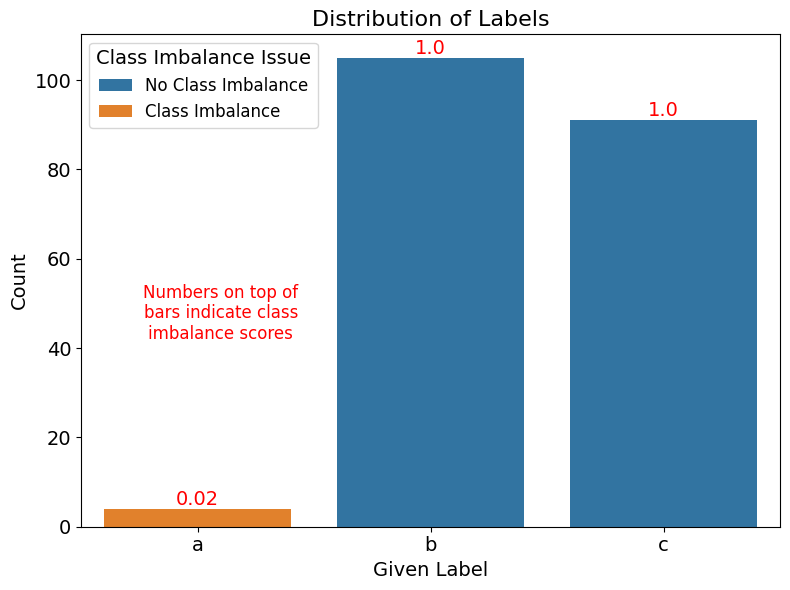

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot the distribution of labels in the dataset
ax = sns.countplot(x="given_label", data=class_imbalance_issues, order=["a", "b", "c"], hue="is_class_imbalance_issue")
plt.title("Distribution of Labels", fontsize=16)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Given Label", fontsize=14)
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)

# Annotate plot with score of each issue class
for i, given_label in enumerate(["a", "b", "c"]):
    filtered_df = class_imbalance_issues.query("given_label == @given_label")
    score = filtered_df["class_imbalance_score"].mean()
    y = len(filtered_df)
    plt.annotate(f"{round(score, 5)}", xy=(i, y), ha="center", va="bottom", fontsize=14, color="red")

# Add textual annotation to explain the scores
plt.text(0.1, max(ax.get_yticks()) * 0.35, "Numbers on top of\nbars indicate class\nimbalance scores", ha='center', fontsize=12, color='red')

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["No Class Imbalance", "Class Imbalance"], title="Class Imbalance Issue", fontsize=12, title_fontsize='14')

plt.tight_layout()
plt.show()

In [32]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.


# Only one example should suffer from null issues (other just have low scores)
assert set(null_issues.query("is_null_issue").index) == {8}, "Null issues are not as expected."

# Ensure that the tutorial dataset finds underperforming group based on clustering results
assert underperforming_group_issues["is_underperforming_group_issue"].sum() > 0, "No underperforming group issues detected."

# Top of non-iid issues show a flag
assert non_iid_issues.head(10).is_non_iid_issue.sum() > 0, "No non-iid issues detected at the top of the non-iid issues."

# Pre-computed knn-graph section looks for the following issue types, except non-iid
assert {"null", "label", "outlier", "near_duplicate", "non_iid", "class_imbalance", "underperforming_group"}.issuperset(issue_summary["issue_type"]), "Issue types are not as expected."

# Ensure that class imbalance score is correct
assert all(class_imbalance_issues.query("is_class_imbalance_issue")["class_imbalance_score"] == 0.02), "Class imbalance issue scores are not as expected"
assert all(class_imbalance_issues.query("not is_class_imbalance_issue")["class_imbalance_score"] == 1.0), "Class imbalance issue scores are not as expected"

## Identify Spurious Correlations in Image Datasets

This section demonstrates how to detect spurious correlations in image datasets by measuring how strongly individual image properties correlate with class labels.
These correlations could lead to unreliable model predictions and poor generalization.

`Datalab` automatically analyzes image-specific attributes such as:

- Darkness
- Blurriness
- Aspect ratio anomalies
- More image-specific features from [CleanVision](https://cleanvision.readthedocs.io/en/latest/tutorials/tutorial.html#What-is-CleanVision?)

This analysis helps identify unintended biases in datasets and guides steps to enhance the robustness of machine learning models.


### 1. Load the Dataset

For this tutorial, we'll use a subset of the CIFAR-10 dataset with artificially introduced biases to illustrate how Datalab detects spurious correlations. We'll assume you have a directory of images organized into subdirectories by class.

To fetch the data for this tutorial, make sure you have `wget` and `zip` installed.

In [33]:
# Download the dataset
!wget -nc https://s.cleanlab.ai/CIFAR-10-subset.zip
!unzip -q CIFAR-10-subset.zip

--2024-09-03 16:19:59--  https://s.cleanlab.ai/CIFAR-10-subset.zip
Resolving s.cleanlab.ai (s.cleanlab.ai)... 185.199.110.153, 185.199.111.153, 185.199.108.153, ...
Connecting to s.cleanlab.ai (s.cleanlab.ai)|185.199.110.153|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 986707 (964K) [application/zip]
Saving to: ‘CIFAR-10-subset.zip’

CIFAR-10-subset.zip   0%[                    ]       0  --.-KB/s               

CIFAR-10-subset.zip 100%[===================>] 963.58K  --.-KB/s    in 0.04s   

2024-09-03 16:19:59 (26.0 MB/s) - ‘CIFAR-10-subset.zip’ saved [986707/986707]



In [34]:
from datasets import Dataset
from torchvision.datasets import ImageFolder

def load_image_dataset(data_dir: str):
    """
    Load images from a directory structure and create a datasets.Dataset object.
    
    Parameters
    ----------
    data_dir : str
        Path to the root directory containing class subdirectories.
    
    Returns
    -------
    datasets.Dataset
        A Dataset object containing 'image' and 'label' columns.
    """
    image_dataset = ImageFolder(data_dir)
    images = [img for img, _ in image_dataset]
    labels = [label for _, label in image_dataset]
    return Dataset.from_dict({"image": images, "label": labels})

# Load the dataset
data_dir = "CIFAR-10-subset/darkened_images"
dataset = load_image_dataset(data_dir)

### 2. Run Datalab Analysis

Now that we have loaded our dataset, let's use `Datalab` to analyze it for potential spurious correlations.

Finding class_imbalance issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/200 [00:00<?, ?it/s]

Removing dark, blurry from potential issues in the dataset as it exceeds max_prevalence=0.1
Finding spurious correlation issues in the dataset ...

Audit complete. 0 issues found in the dataset.
No issues found in the data. Good job!

Try re-running Datalab.report() with `show_summary_score = True` and `show_all_issues = True`.



Removing dark from potential issues in the dataset as it exceeds max_prevalence=0.1 
Removing blurry from potential issues in the dataset as it exceeds max_prevalence=0.1 



Summary of (potentially spurious) correlations between image properties and class labels detected in the data:

Lower scores below correspond to images properties that are more strongly correlated with the class labels.


       property  score
low_information  0.015
          light  0.180
           dark  0.000
         blurry  0.015

Here are the images corresponding to the extreme (minimum and maximum) individual scores for each of the detected correlated properties:


Images with min

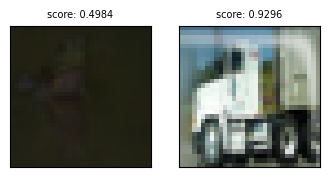

Images with minimum and maximum individual scores for light issue:



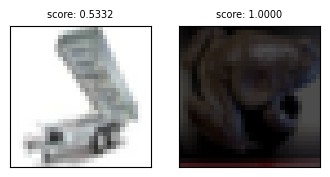

Images with minimum and maximum individual scores for dark issue:



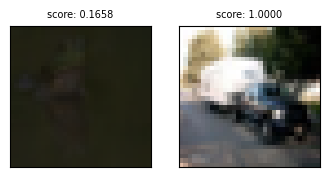

Images with minimum and maximum individual scores for blurry issue:



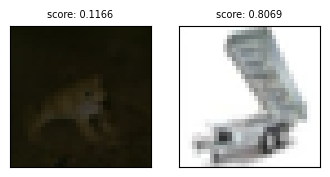

In [35]:
from cleanlab import Datalab

# Initialize Datalab with the dataset
lab = Datalab(data=dataset, label_name="label", image_key="image")

# Run the analysis
lab.find_issues()

# Generate and display the report
lab.report()

### 3. Interpret the Results

While the `lab.report()` output is comprehensive, we can use more targeted methods to examine the results:

In [36]:
from IPython.display import display

# Get scores for label uncorrelatedness with image properties
label_uncorrelatedness_scores = lab.get_info("spurious_correlations")["correlations_df"]
print("Label uncorrelatedness scores for image properties:")
display(label_uncorrelatedness_scores)

# Get image-specific issues
issue_name = "dark"
image_issues = lab.get_issues(issue_name)
print("\nImage-specific issues:")
display(image_issues)

Label uncorrelatedness scores for image properties:


,property,score
0,odd_size_score,0.500
1,odd_aspect_ratio_score,0.500
2,low_information_score,0.015
3,light_score,0.180
4,grayscale_score,0.500
5,dark_score,0.000
6,blurry_score,0.015



Image-specific issues:


,is_dark_issue,dark_score
0,True,0.237196
1,True,0.197229
2,True,0.254188
3,True,0.229170
4,True,0.208907
...,...,...
195,False,0.793840
196,False,1.000000
197,False,0.971560
198,False,0.862236


Interpreting the results:

1. **Label Uncorrelatedness Scores**: The `label_uncorrelatedness_scores` DataFrame shows scores for various image properties. Lower scores (closer to 0) indicate stronger correlations with class labels, suggesting potential spurious correlations.
2. **Image-Specific Issues**: The `image_issues` DataFrame provides details on detected image-specific problems, including the issue type and affected samples.

In our CIFAR-10 subset example, you should see that the 'dark' property has a low score in the label_uncorrelatedness_scores, indicating a strong correlation with one of the classes (likely the 'frog' class). This is due to our artificial darkening of these images to demonstrate the concept.

For real-world datasets, pay attention to:

- Properties with notably low scores in the label_uncorrelatedness_scores DataFrame
- Prevalent issues in the image_issues DataFrame

These may represent unintended biases in your data collection or preprocessing steps and warrant further investigation.

> **Note**: Using these methods provides a more programmatic and focused way to analyze the results compared to the verbose output of `lab.report()`.

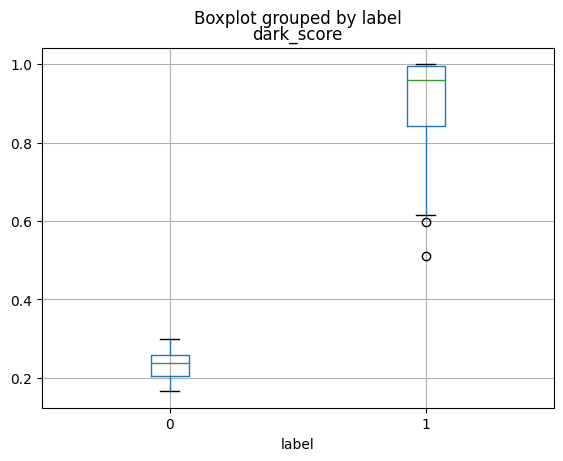

In [37]:
def plot_scores_labels(lab, property="dark_score"):
    """
    Plots the scores of image-specific properties like 'dark_score', 'blurry_score', etc. 
    against labels for each instance in the dataset using 'Datalab' object.

    Parameters:
    -----------
    lab : 'Datalab' object
    
    property : str, optional
        The name of the property to be plotted against the labels.
    
    Returns:
    --------
    None
        This function does not return any value. It generates a plot of the specified 
        property against the labels.
    """
    issues_copy = lab.issues.copy()
    issues_copy["label"] = lab.labels
    issues_copy.boxplot(column=[property], by="label")

# Plotting 'dark_score' value of each instance in the dataset against class label
plot_scores_labels(lab, "dark_score")

The above plot illustrates the distribution of dark scores across class labels. In this dataset, 100 images from the `Frog` class (Class 0 in the plot) have been darkened, while 100 images from the `Truck` class (Class 1 in the plot) remain unchanged, as in the CIFAR-10 dataset. This creates a clear spurious correlation between the 'darkness' feature and the class labels: `Frog` images are dark, whereas `Truck` images are not. We can see that the `dark_score` values between the two classes are non-overlapping. This characteristic of the dataset is identified by `Datalab`.

### 4. (Optional) Compare with a Dataset Without Spurious Correlations

To understand the impact of spurious correlations, it can be helpful to compare our results with a dataset that doesn't have artificially introduced biases. In this case, we'll use the original CIFAR-10 subset.

In [38]:
# Load the original dataset
original_data_dir = "CIFAR-10-subset/original_images"
original_dataset = load_image_dataset(original_data_dir)

# Create a new Datalab instance and run analysis
original_lab = Datalab(data=original_dataset, label_name="label", image_key="image")
original_lab.find_issues()

# Compare correlation scores
original_scores = original_lab.get_info("spurious_correlations")["correlations_df"]
print("Label uncorrelatedness scores for original dataset:")
display(original_scores)

# Compare image-specific issues
original_issues = original_lab.get_issues("dark")
print("\nImage-specific issues in original dataset:")
display(original_issues)

Finding class_imbalance issues ...
Finding dark, light, low_information, odd_aspect_ratio, odd_size, grayscale, blurry images ...


  0%|          | 0/200 [00:00<?, ?it/s]

Finding spurious correlation issues in the dataset ...

Audit complete. 0 issues found in the dataset.
Label uncorrelatedness scores for original dataset:


,property,score
0,odd_size_score,0.500
1,odd_aspect_ratio_score,0.500
2,low_information_score,0.325
3,light_score,0.415
4,grayscale_score,0.500
5,dark_score,0.300
6,blurry_score,0.335



Image-specific issues in original dataset:


,is_dark_issue,dark_score
0,False,0.797509
1,False,0.663760
2,False,0.849826
3,False,0.773951
4,False,0.699518
...,...,...
195,False,0.793840
196,False,1.000000
197,False,0.971560
198,False,0.862236


When comparing the results:

1. Look for differences in the label uncorrelatedness scores, especially for the 'dark' property.
2. Compare the number and types of image-specific issues detected.

You should notice that the original dataset has more balanced correlation scores and fewer (or no) issues related to darkness. This comparison highlights how spurious correlations can be detected by `Datalab`.

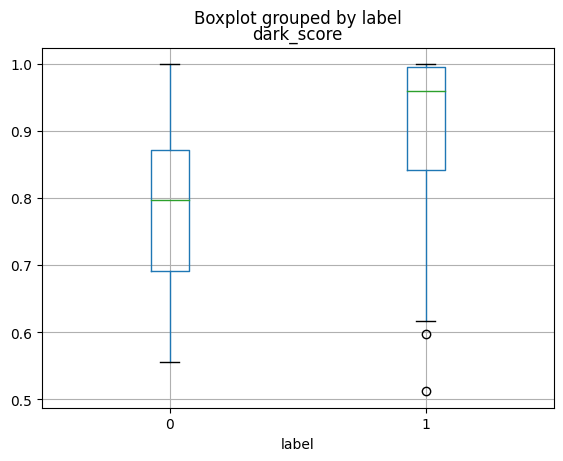

In [39]:
# Plotting 'dark_score' value of each instance in the original dataset against class label
plot_scores_labels(original_lab, "dark_score")

The above plot illustrates the distribution of dark scores across class labels. In this dataset, 100 images each from the classes `Frog` (Class 0 in the plot) and `Truck` (Class 1 in the plot) remain unchanged, as in the CIFAR-10 dataset. There is no apparent spurious correlation with respect to the 'darkness' feature and class labels. We can see that the `dark_score` values between the two classes are highly overlapping.